https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?select=train.txt

https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset/code?datasetId=99505&sortBy=voteCount

https://www.kaggle.com/code/jonathanoheix/face-expression-recognition-with-deep-learning

https://www.kaggle.com/code/nakulsingh1289/face-expression-detection-from-scratch

https://www.kaggle.com/code/abduulrahmankhalid/emotion-based-music-recommender-resnet50v2

https://www.kaggle.com/code/infinator/mood-detection-and-song-recommendation

https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from numpy.random import seed
from tensorflow.random import set_seed
import warnings
warnings.filterwarnings("ignore")

def set_Mseed(Myseed = 42):    
    seed(Myseed)
    random.seed(Myseed)
    set_seed(Myseed)

set_Mseed()

In [3]:
# 28,000 images of 48 * 48 pixels
# 7 emotions: (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

MAIN_DIR = "/kaggle/input/fer2013"
TRAIN_DIR = "/kaggle/input/fer2013/train"
TEST_DIR = "/kaggle/input/fer2013/test"
EMOTIONS = [f for f in os.listdir("/kaggle/input/fer2013/train")]

# Exploratory Data Analysis

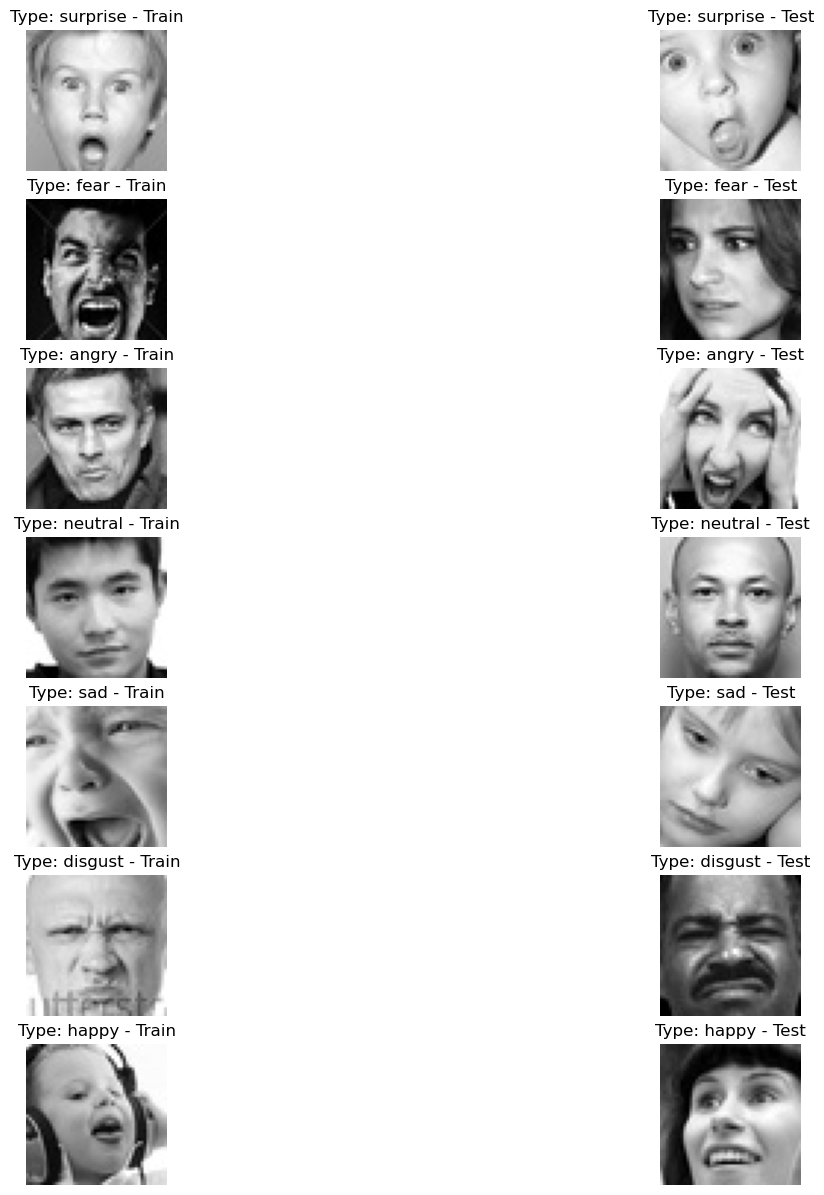

In [44]:
# Randomly chosen images for each emotion from train & test

from PIL import Image

def random_file(dirpath, subfold):    
    return random.choice(os.listdir(os.path.join(dirpath, subfold)))

def random_imgs():
    imgs = {}
    for emote in EMOTIONS:
        if emote not in imgs:
            imgs[emote] = []
        imgs[emote].append(random_file(TRAIN_DIR, emote))
        imgs[emote].append(random_file(TEST_DIR, emote))

    # Display them
    f, axs = plt.subplots(7, 2, figsize = (15, 15))

    for i, emote in enumerate(imgs.keys()):

        train, test = imgs[emote]
        train = os.path.join(os.path.join(TRAIN_DIR, emote), train)
        test = os.path.join(os.path.join(TEST_DIR, emote), test) 
        
        # convert image to grayscale -> np.array -> cmap = 'grey' else purple-green combo
        axs[i, 0].imshow(np.array(Image.open(train)), cmap = 'gray')
        axs[i, 0].set_title(f'Type: {emote} - Train')

        axs[i, 1].imshow(np.array(Image.open(test)), cmap = 'gray')
        axs[i, 1].set_title(f'Type: {emote} - Test')

        axs[i, 0].axis('off')
        axs[i, 1].axis('off')

    plt.show()

random_imgs()

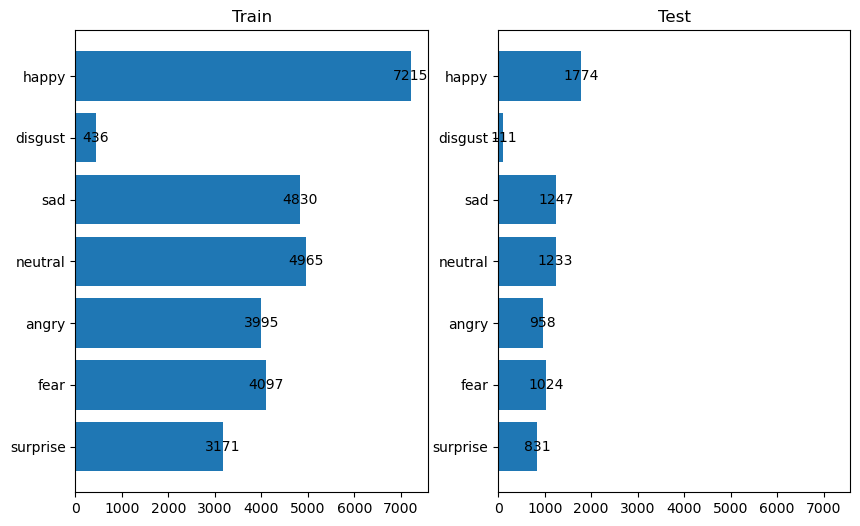

In [45]:
# Counting number of photos for each emotion in train & test folder

def classCounts():
    
    f, axs = plt.subplots(1, 2, figsize = (10, 6), sharex = True)
    
    for cnt, path in enumerate([TRAIN_DIR, TEST_DIR]):
        imgs = {}
        for emote in EMOTIONS:
            if emote not in imgs:
                imgs[emote] = 0
            imgs[emote] += len(os.listdir(os.path.join(path, emote)))

        axs[cnt].barh(list(imgs.keys()), list(imgs.values()))
        

        if 'train' in path:
            axs[cnt].set_title('Train')
        else:
            axs[cnt].set_title('Test')

        for i, freq in enumerate(list(imgs.values())):
            axs[cnt].text(freq, i, str(freq), ha='center', va='center')
        
classCounts()

### Observations

1. For each emotion, number of train/test samples ~ 4:1
2. num of images
    1. 'disgust': least
    2. 'happy': most
3. This imabalance problem is solved by class-weighting(lower freq: error more penalized)
    1. Other methods like gaining domain knowledge, data resampling, ensemble methods, transfer learning avoided, greater data collection for now due to easeness of class-weights.
4. Metrics: precision, recall, F1-score, or AUC-ROC that are less sensitive to class imbalances.

References for image_dataset_from_directory(data loading):
1. https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

# Creating DataLoaders

In [4]:
# label_mode == "int": to use sparse_categorical_crossentropy(faster than cross) as loss function

from tensorflow.keras.utils import image_dataset_from_directory

# Setting params for data loader
batchSize = 128
height = 48
width = 48

# creating dataloaders for train & val
trainDL, valDL = image_dataset_from_directory(TRAIN_DIR, 
                                              color_mode = "grayscale",
                                               labels = "inferred",
                                               batch_size = batchSize,
                                               image_size = (height, width),
                                               seed = 42,
                                               validation_split = 0.10,
                                               subset = "both",
                                               label_mode = "int")

# creating dataloaders for test
testDL = image_dataset_from_directory(TEST_DIR,
                                       labels = "inferred", 
                                      color_mode = "grayscale",
                                       batch_size = batchSize,
                                       image_size = (height, width),
                                       label_mode = "int",
                                       shuffle = False)

Found 28709 files belonging to 7 classes.
Using 25839 files for training.
Using 2870 files for validation.
Found 7178 files belonging to 7 classes.


tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


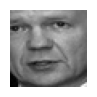

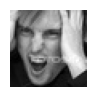

In [56]:
from tensorflow.image import rgb_to_grayscale

for imgs, labs in trainDL:
    cnt = 0
    for img, lab in zip(imgs, labs):
        cnt += 1
        plt.figure(figsize=(1, 1))
        plt.imshow(img, cmap='gray') # (1, 48, 48, 1)
        plt.axis('off')
        print(lab)
        if cnt >= 2:
            break
    break

# Handling Class Imbalance for 'disgust' by computing class weights



References:
1. https://stackoverflow.com/questions/69783897/compute-class-weight-function-issue-in-sklearn-library-when-used-in-keras-cl
2. https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
3. https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
4. https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

In [5]:
# Extract the labels from the dataset as a 1D list
train_labels = []
for images, labels in trainDL:
    train_labels.extend(labels.numpy())
    
# be careful of positional arguments
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes = np.unique(train_labels), y = train_labels)

class_weights 

array([1.02223365, 9.2979489 , 1.00634834, 0.5660613 , 0.82468403,
       0.84974349, 1.30803888])

There are two important points to be aware of in this case:

1. Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

2. When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

Note: ***Data augmentation is inactive at test time so input images will only be augmented during calls to Model.fit (not Model.evaluate or Model.predict).***

# Building Model

In [6]:
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Dropout, BatchNormalization
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam

from keras.layers import Rescaling, RandomFlip, RandomRotation

from tensorflow.keras.utils import plot_model


References:
1. https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/
2. https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2
3.[Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/#:~:text=2D%20convolution%20layer%20(e.g.%20spatial,to%20the%20outputs%20as%20well.)

1. While setting up a fairly simple classification task, two convolutional layers will usually be enough. And then the number of layers can be increased if the resulting accuracy is too low.
2. The appropriate number of nodes is also highly dependent on the complexity of the images and the task at hand. By varying the number of nodes and evaluating the resulting accuracy, the model can be run multiple times until a satisfying result is achieved.
3. In a pooling layer, a filter is applied to the different areas of an image. The window size and stride will decide the size of the output and how the filter is moved over the input matrix. The most common is to choose window size (2, 2) and stride 2.
    1. There’s no textbook answer for how often a pooling layer should be applied, and the developer will again be encouraged to iterate until an acceptable answer is reached.
4. There isn’t necessarily a correct answer to how many fully connected layers should be chosen in a CNN model. For most models, however, it’d be sufficient to start with one or two fully connected layers, later adjusting the number depending on the resulting performance.
5. Dropout layers can be convenient to apply to fully connected layers and convolutional layers.
6. For example, the filter size is one such hyperparameter you should specify before training your network.
    1. For an image recognition problem, if you think that a big amount of pixels are necessary for the network to recognize the object you will use large filters (as 11x11 or 9x9). If you think what differentiates objects are some small and local features you should use small filters (3x3 or 5x5). These are some tips but do not exist any rules.

Principles
The appropriate number of layers and nodes is usually found by applying a set of the below approaches:

1. Experimentation: Try different number of layers and nodes
2. Intuition: Use previous experience to choose the number of layers and nodes
3. Go for depth: Deep neural networks often perform better than shallow ones
4. Borrow ideas: Borrow ideas from articles describing similar projects
5. Search: Create an automated search to test different architectures

# Original Model

In [10]:
def customCNN(num_classes = len(trainDL.class_names), height = 48, width = 48, rescale = 1.0/255.0, rotation_range = 0.2):
    
    # initialising model
    model = Sequential()
    
    # augmenting input images from trainDL
    model.add(Rescaling(rescale))
    model.add(RandomFlip("horizontal"))
    model.add(RandomRotation(rotation_range))
    
    # 1st convolution (num filters, filter size, padding provided: same = yes)
    model.add(Conv2D(64, (3, 3), padding = 'same',
                     input_shape = (height, width, 1),
                    activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    # 2nd convolution layer 
    model.add(Conv2D(128, (5, 5), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    # 3rd Convolution layer
    model.add(Conv2D(512, (3, 3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # 4th Convolution layer
    model.add(Conv2D(512, (3, 3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    # Fully connected layer 1st layer
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Fully connected layer 2nd layer
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Output layer
    model.add(Dense(num_classes, activation = 'softmax'))
    
    # Compiling model
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',  metrics=['accuracy'])
    
    return model

# Model Hyperparamter tuning using keras tuner

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory
from kerastuner.tuners import RandomSearch

def build_model(hp):
    
    # Set the hyperparameters to search    
    num_filters = hp.Int('num_filters', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    dense_units = hp.Choice('dense_units', values=[128, 256, 512])
    
    # Initialize the model
    model = Sequential()
    
    # Augment input images from trainDL
    model.add(Rescaling(1.0/255.0))
    model.add(RandomFlip("horizontal"))
    model.add(RandomRotation(0.2))
    
    # 1st convolution
    model.add(Conv2D(num_filters, (3, 3), padding='same', input_shape=(height, width, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    # 2nd convolution
    model.add(Conv2D(num_filters*2, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    # 3rd convolution
    model.add(Conv2D(num_filters*4, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    # 4th convolution
    model.add(Conv2D(num_filters*8, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(dense_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(dense_units/2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(len(trainDL.class_names), activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Set the desired search parameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='/kaggle/working/',
    project_name='/kaggle/working/models'
)

# Perform the hyperparameter search
tuner.search(trainDL, epochs=10, validation_data=valDL)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0] 

Trial 10 Complete [00h 02m 19s]
val_accuracy: 0.46794426441192627

Best val_accuracy So Far: 0.5282229781150818
Total elapsed time: 00h 26m 17s


In [8]:
best_model = tuner.get_best_models(num_models=1)[0] 

In [14]:
tuner.get_best_hyperparameters()[0].values

{'num_filters': 96, 'dropout_rate': 0.2, 'dense_units': 128}

# Performace Chart

1. old 3D
    1. not good performance (less than baseline by 0.03) 
        1. {'num_filters': 128, 'dropout_rate': 0.2, 'dense_units': 128}
2. old 1D
    1. okish performance
        1. {'num_filters': 64, 'dropout_rate': 0.2, 'dense_units': 512}
3. v1:tuned 1D
    1. 

# Training tuned model

In [58]:
# Plotting history on train 
def plotHistory(history):
    
    f, axs = plt.subplots(1, 2, figsize = (10, 6))
    
    for cnt, metric in enumerate(['loss', 'accuracy']):

        if metric == 'loss':
            axs[cnt].plot(history.history['loss'], label = f'Train {metric}')
            axs[cnt].plot(history.history['val_loss'], label = f'Validation {metric}')
            axs[cnt].set_title('Loss')
        else:
            axs[cnt].plot(history.history['accuracy'], label = f'Train {metric}')
            axs[cnt].plot(history.history['val_accuracy'], label = f'Validation {metric}')
            axs[cnt].set_title('Accuracy')
        
        axs[cnt].set_xlabel('# Epochs')
        axs[cnt].set_ylabel(f'{metric}')
        axs[cnt].legend()

In [16]:
def CNNHT(num_filters, dropout_rate, dense_units, num_classes = len(trainDL.class_names), height = 48, width = 48, rescale = 1.0/255.0, rotation_range = 0.2):
    
    # Initialize the model
    model = Sequential()
    
    # Augment input images from trainDL
    model.add(Rescaling(rescale))
    model.add(RandomFlip("horizontal"))
    model.add(RandomRotation(rotation_range))
    
     # 1st convolution
    model.add(Conv2D(num_filters, (3, 3), padding='same', input_shape=(height, width, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    # 2nd convolution
    model.add(Conv2D(num_filters*2, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    # 3rd convolution
    model.add(Conv2D(num_filters*4, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    # 4th convolution
    model.add(Conv2D(num_filters*8, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(dense_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(dense_units/2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(len(trainDL.class_names), activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
tuner.get_best_hyperparameters()[0].values

{'num_filters': 96, 'dropout_rate': 0.2, 'dense_units': 128}

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

checkpoint = ModelCheckpoint("/kaggle/working/best_model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping_monitor = EarlyStopping(patience = 20)
callbacks_list = [checkpoint, early_stopping_monitor]

# Update Before running
maxEpochs = 200
model = CNNHT(96, 0.2, 128)

def trainModel(model):    

    history = model.fit_generator(generator=trainDL,
                                    steps_per_epoch = len(trainDL),
                                    epochs = maxEpochs,
                                    validation_data = valDL,
                                    validation_steps = len(valDL),
                                    callbacks=callbacks_list,
                                    class_weight = class_weights_dict
                                    )
    
#     model.save(f"htCNNfinal.h5")
    
trainModel(model)

Epoch 1/200


2023-07-08 20:31:37.985670: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


202/202 [==============================] - 16s 67ms/step - loss: 2.1375 - accuracy: 0.1620 - val_loss: 1.9439 - val_accuracy: 0.1711
Epoch 2/200
202/202 [==============================] - 13s 60ms/step - loss: 2.0025 - accuracy: 0.1794 - val_loss: 1.9763 - val_accuracy: 0.1704
Epoch 3/200
202/202 [==============================] - 13s 63ms/step - loss: 1.9462 - accuracy: 0.1907 - val_loss: 1.9249 - val_accuracy: 0.1941
Epoch 4/200
202/202 [==============================] - 11s 53ms/step - loss: 1.8966 - accuracy: 0.2097 - val_loss: 1.8958 - val_accuracy: 0.2094
Epoch 5/200
202/202 [==============================] - 12s 59ms/step - loss: 1.8609 - accuracy: 0.2254 - val_loss: 1.8592 - val_accuracy: 0.2307
Epoch 6/200
202/202 [==============================] - 11s 55ms/step - loss: 1.8298 - accuracy: 0.2468 - val_loss: 1.8061 - val_accuracy: 0.2944
Epoch 7/200
202/202 [==============================] - 12s 56ms/step - loss: 1.7842 - accuracy: 0.2816 - val_loss: 1.8255 - val_accuracy: 0.26

In [19]:
model.save("optimizedCNN.h5")

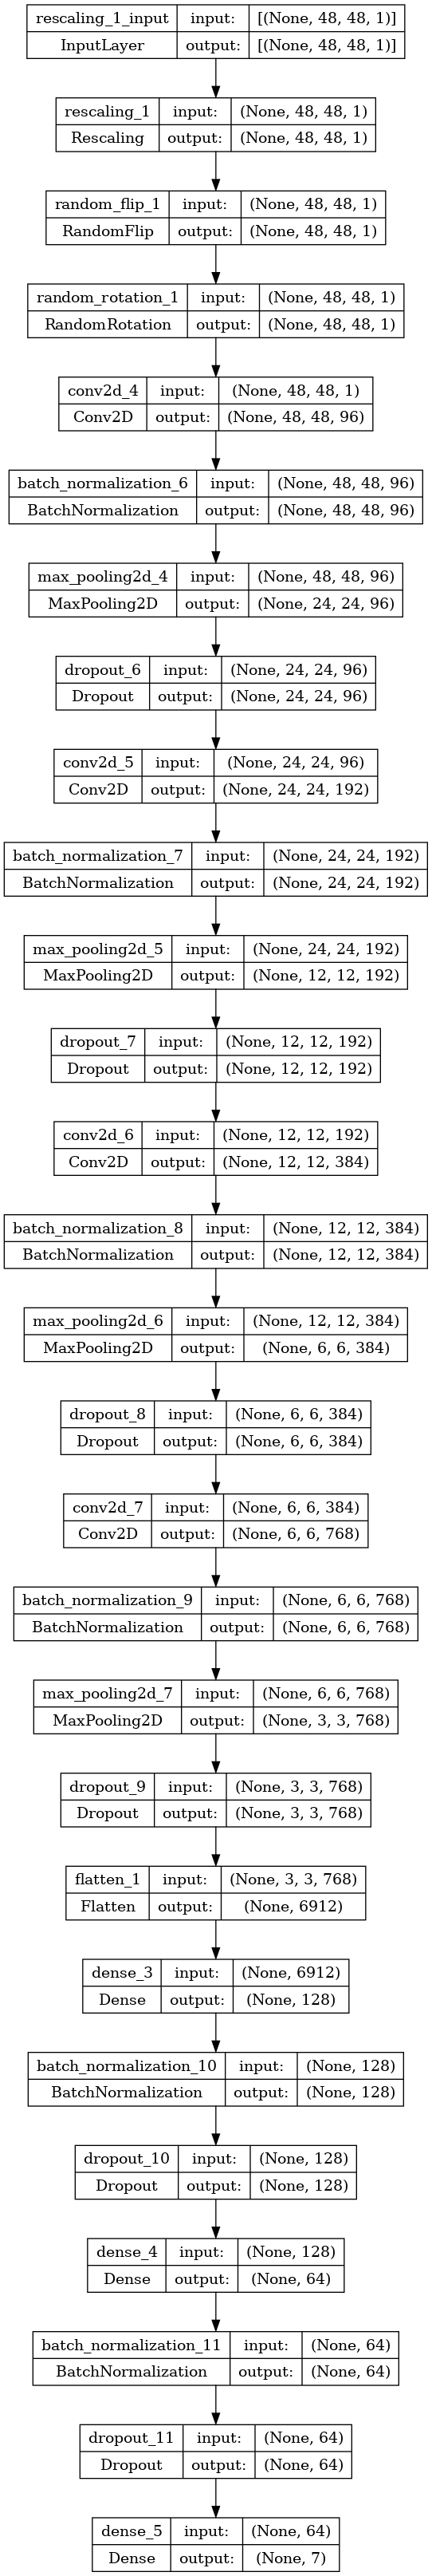

In [20]:
plot_model(model, to_file = "model.png", show_shapes = True)

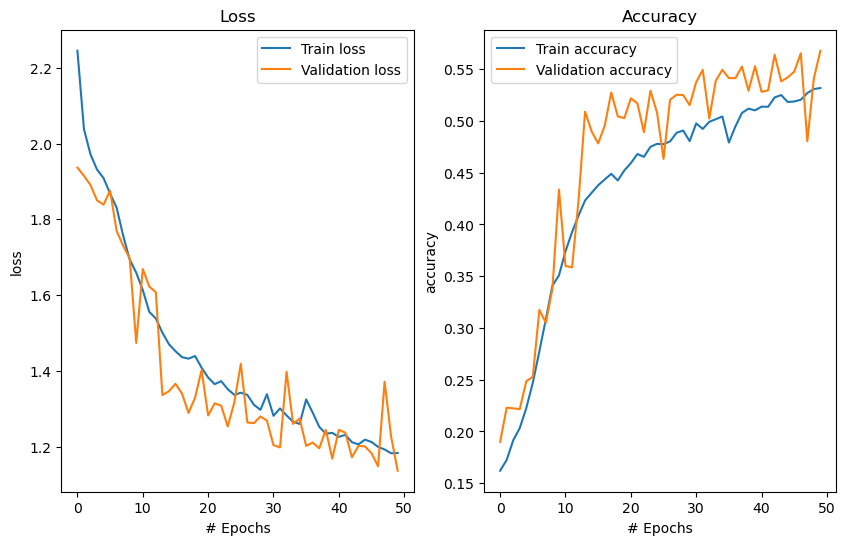

In [60]:
plotHistory(history)

# Predictions from model on test data

In [21]:
from tensorflow.keras.models import load_model
model = load_model("/kaggle/working/optimizedCNN.h5")

In [22]:
# object.__dict__['class_names'] containes all the properties that has been specified for the object

from tqdm import tqdm
preds = model.predict_generator(generator = testDL)
preds = [np.argmax(probs) for probs in tqdm(preds)]
for i in range(len(preds)):
    preds[i] = testDL.__dict__['class_names'][preds[i]]
    
ytest = []
for _, labs in testDL:
    for i in range(len(labs)):
        ytest.append(testDL.__dict__['class_names'][labs[i]])

100%|██████████| 7178/7178 [00:00<00:00, 225848.35it/s]


<Figure size 640x480 with 0 Axes>

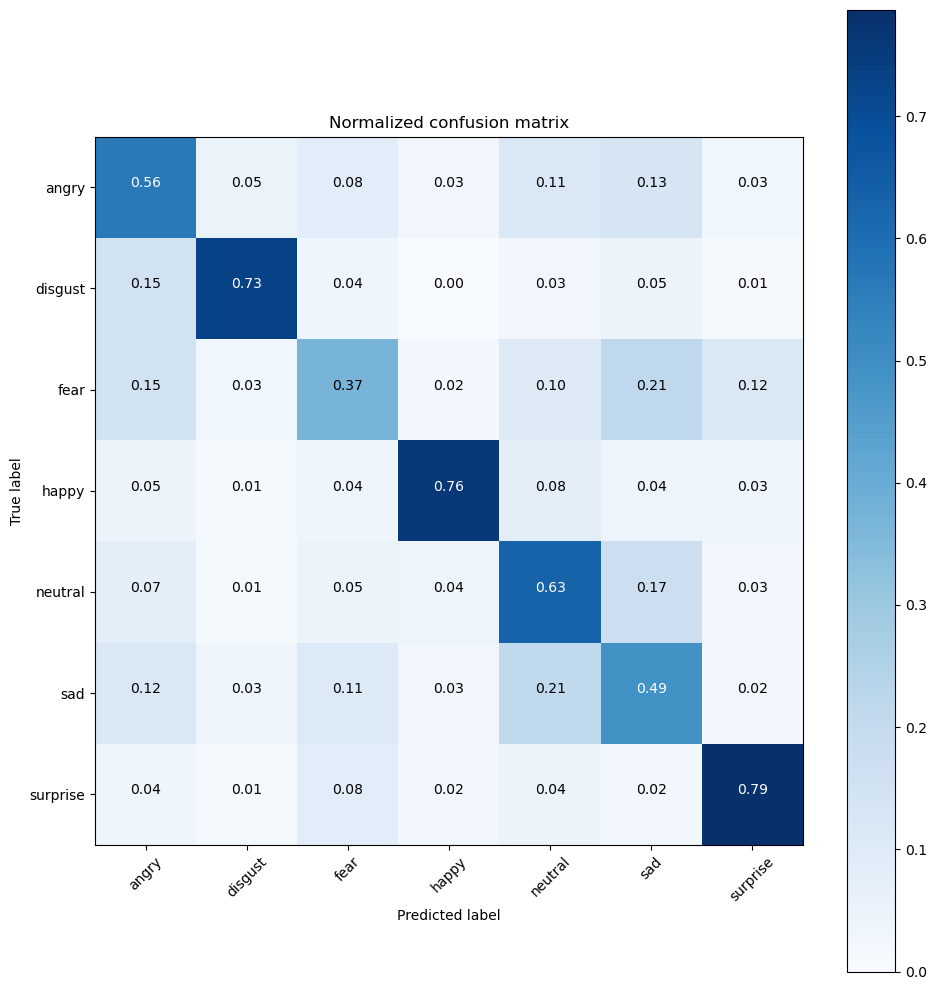

In [23]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(ytest, preds)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=testDL.__dict__['class_names'], title='Normalized confusion matrix')


Other guy analysis: 
Our model is very good for predicting happy and surprised faces. However it predicts quite poorly feared faces because it confuses them with sad faces.

With more research and more resources this model could certainly be improved, but the goal of this study was primarily to focus on obtaining a fairly good model compared to what has been done in this field.

Now it's time to try our model in a real situation! We will use flask to serve our model in order to perform real-time predictions with a webcam input.